In [2]:
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt
pi = math.pi

#Prints out numbers without "np.flat64" displaying
np.set_printoptions(legacy='1.25')

## Problem 5.16

### a) Plotting Reflection Coefficient of a N=4 Binomial Matching Transformer

In [3]:
def create_binomial_transformer(N,Zo,ZL) :
    ''' Generates impedences for a Binomial Multisection Matching Transformer
        INPUTS:
            N: number of matching segments
            Zo: line impedence
            ZL: load impedence to match to line
        RETURNS:
            Array of all impedences, starting with Zo, then the matching segments, then ZL.
        '''
    impedence = [Zo]
    for n in range(1,N+1):
        Cn = (math.factorial(N)) / (math.factorial(N-(n-1)) * math.factorial(n-1))
        Zn = np.exp(np.log(impedence[n-1]) + 2**(-N) * Cn*np.log(ZL/Zo))
        impedence.append(Zn)
    
    del impedence[0]
    
    return impedence

In [4]:
N = 4
Zo = 50
ZL = 12.5

A_mag = abs((2**(-N)) * ((ZL - Zo)/(ZL + Zo)))



In [5]:
N = 4
Zo = 50
ZL = 12.5

A_mag = abs((2**(-N)) * ((ZL - Zo)/(ZL + Zo)))


input = np.linspace(0.25,1.75,num=300) # vector of f from 0.5 to 2 in over 100 slices
frequency_ratio = [element for element in input] #frequency = x-axis
ref_mag = [999] * len(input)

index=0
for f in input :
    ref_mag[index] = (2**N) * A_mag * (abs(np.cos((pi/2)*f))**N)

    index+=1

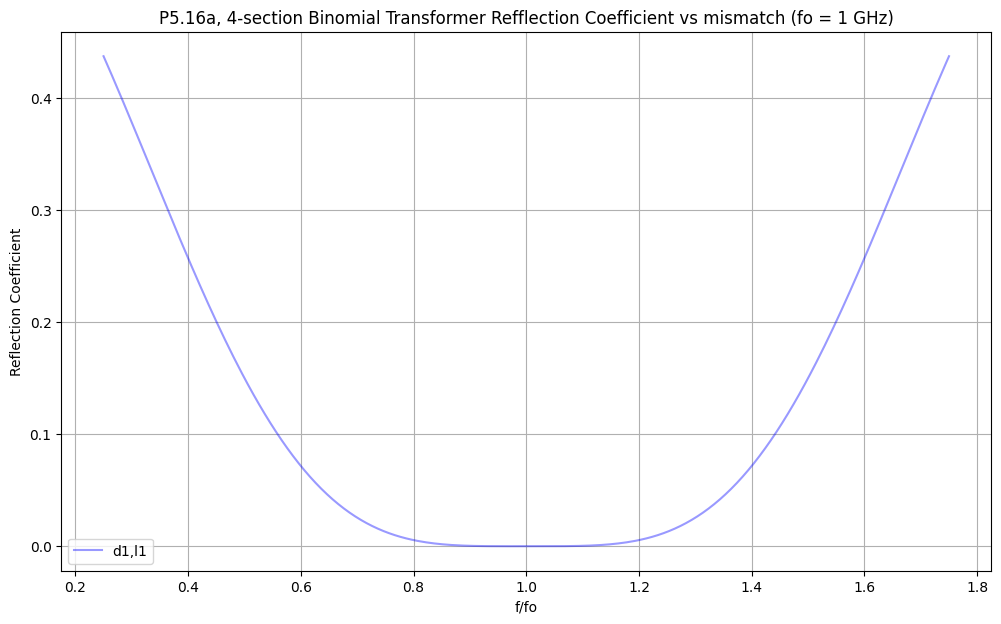

In [6]:
#Plotting the data
fig = plt.figure(figsize = (12,7))

plt.plot(frequency_ratio,ref_mag, alpha = 0.4, label='d1,l1', color='blue')
plt.title('P5.16a, 4-section Binomial Transformer Refflection Coefficient vs mismatch (fo = 1 GHz)')
plt.xlabel('f/fo')
plt.ylabel('Reflection Coefficient')
plt.grid()
plt.legend()

### b) Microstrip Implementation

In [7]:
# Constants
epsilon_0 = 8.854*10**-12 #permitivity of free space
mu_0 = 4*pi*10**-7 #permeability of free space
c = 2.998*10**8 #speed of light

In [8]:
# Generic Equations

def freq_to_omega(freq) : #get angular frequency (rad/s)
    return 2*pi*freq

def Np_to_dB(Np) : # converts Nepers to Decibels.
    return Np*20/(np.log(10))

#mu_r, epsilon_r = relative properties of medium
#freq = frequency of propagation
def calc_wavenumber(mu_r, epsilon_r, freq) : # wavenumber, k
    return freq_to_omega(freq)*np.sqrt(mu_r*mu_0*epsilon_r*epsilon_0)

# k = wavenumber
def calc_SL_guide_wavelength(k) : # lambda_g
    return 2*pi/k

#frequency = frequency of propagation
#conductance = property of conductor, sigma
def calc_surface_resistance(frequency,conductance) :
    return np.sqrt((freq_to_omega(frequency)*mu_0)/(2*conductance))

Microstrip Equations

In [ ]:
#epsilon_r = relative permitivity of dialectric
#Zo = desired characteristic impedence of line
#d = substrate thickness
def calc_MS_width(epsilon_r, Zo,d) :
    A = (Zo/60)*(np.sqrt((epsilon_r+1)/2)) + ((epsilon_r-1)/(epsilon_r+1))*(0.23 + (0.11)/epsilon_r)
    B = 377*pi/(2*Zo*np.sqrt(epsilon_r))
    #print(f'A = {A}')
    #print(f'B = {B}')
    W = (8*np.exp(A)/(np.exp(2*A)-2))*d
    if (W/d) <= 2 :
        #print(f'W/d <= 2')
        return W
    else :
        W = ((2/pi)*(B - 1 - np.log(2*B-1) + ((epsilon_r-1)/(2*epsilon_r))*(np.log(B-1) + 0.39 - (0.61/epsilon_r)) ))*d
        return W
    
#epsilon_r = relative permitivity of dialectric
#W = width of copper microstrip (not groundplane)
#d = substrate thickness
def calc_MS_epsilon_effective(epsilon_r, W, d) :
    return ((epsilon_r+1)/(2) + ((epsilon_r-1)/(2))*(1/(np.sqrt(1 + 12*(d/W)))))

#epsilon_r = relative permitivity of dialectric
#tandelta = property of dialectric
#W = width of copper microstrip (not groundplane)
#d = substrate thickness
def calc_MS_dialectric_loss(epsilon_r,freq, tandelta, W, d) :
    k0 = (2*pi*freq/c)
    epsilon_e = calc_MS_epsilon_effective(epsilon_r, W, d)
    return ((k0*epsilon_r*(epsilon_e-1)*tandelta)/(2*np.sqrt(epsilon_e)*(epsilon_r-1)))

#Rs = surface resistance of conductor
#Zo = characteristic impedence of line.
#W = width of copper microstrip (not groundplane)
def calc_MS_conductor_loss(Rs, Zo, W) : 
    return (Rs/(Zo*W))

#Zo = characteristic impedence of line.
#epsilon_r = relative permitivity of dialectric
#freq = frequency of line.
#d = substrate thickness
#tandelta = property of dialectric
#conductance = conductance of conductor.
def calc_MS_total_loss(Zo, epsilon_r, freq, d, tandelta, conductance) :
    Rs = calc_surface_resistance(freq,conductance)
    W = calc_MS_width(epsilon_r, Zo, d)
    #print(f'W = {W}')
    cond_loss = Np_to_dB(calc_MS_conductor_loss(Rs, Zo, W))
    dialectric_loss = Np_to_dB(calc_MS_dialectric_loss(epsilon_r, freq, tandelta, W, d))
    #print(f'Conductor Loss = {cond_loss} dB/m')
    #print(f'Dialectric Loss = {dialectric_loss} dB/m')
    return cond_loss + dialectric_loss

In [10]:
bino_impedences = create_binomial_transformer(N,Zo,ZL)

#given variables
epsilon_r = 4.2
d = 0.158*(10**-2) # meters
tandelta = 0.02
freq_o = (10**9) #design frequency, 1 GHz
copper_conductance = 5.813 * (10**7) #Siemens/meter

input = np.linspace(0.01,2,num=200) # vector of f from 0.01 to 2 in over 200 slices
frequency_ratio = [element for element in input] #frequency = x-axis
loss_arr = [999] * len(input)

index=0
for f in input : # fractional bandwidth. f = actual frequency / freq_o
    freq = f*freq_o #actual frequency

    loss_sum = 0
    for impedence in bino_impedences :
        W = calc_MS_width(epsilon_r, impedence,d)
        epsilon_eff = calc_MS_epsilon_effective(epsilon_r, W, d)
        length = c/(freq_o*np.sqrt(epsilon_eff)*4) 
        loss = calc_MS_total_loss(Zo, epsilon_r, freq, d, tandelta, copper_conductance)*length
        loss_sum = loss_sum + loss

    ref_mag = (2**N) * A_mag * (abs(np.cos((pi/2)*f))**N) #reflection coefficient magnitude
    mismatch_loss = -10*np.log10(1-(ref_mag**2)) #dBs of loss from mismatch. positive value.

    loss_arr[index] = mismatch_loss + loss_sum # total loss for each frequency point.

    index+=1

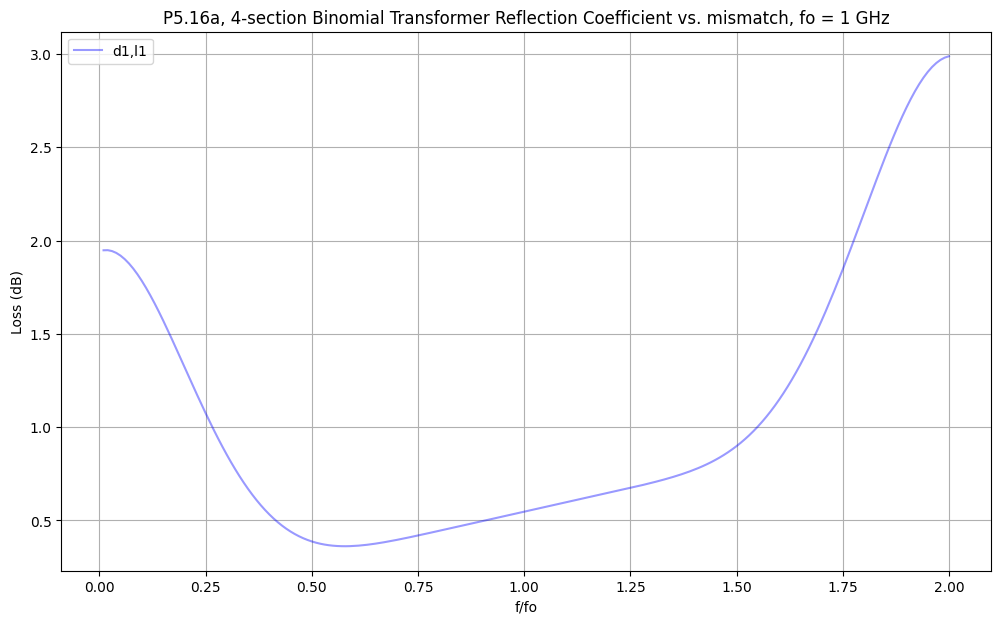

In [11]:
#Plotting the data
fig = plt.figure(figsize = (12,7))

plt.plot(frequency_ratio,loss_arr, alpha = 0.4, label='d1,l1', color='blue')
plt.title('P5.16a, 4-section Binomial Transformer Reflection Coefficient vs. mismatch, fo = 1 GHz')
plt.xlabel('f/fo')
plt.ylabel('Loss (dB)')
plt.grid()
plt.legend()

## Problem 5.18

In [ ]:

Gamma_m = 0.2 #maximum reflection coefficient

input = np.linspace(1.5,6,num=200) # vector of f from 0.01 to 2 in over 200 slices
x_axis = [element for element in input] #frequency = x-axis

N = 1
BW_1 = [999] * len(input)
index = 0
for ZLZo in input :
    A = (2**-N) * ((ZLZo - 1)/(ZLZo + 1))
    BW_1[index] = (2 - (4/pi)*np.arccos(0.5*((Gamma_m/abs(A))**(1/N))))*100

    index+=1

N = 2
BW_2 = [999] * len(input)
index = 0
for ZLZo in input :
    A = (2**-N) * ((ZLZo - 1)/(ZLZo + 1))
    BW_2[index] = (2 - (4/pi)*np.arccos(0.5*((Gamma_m/abs(A))**(1/N))))*100

    index+=1

N = 4
BW_4 = [999] * len(input)
index = 0
for ZLZo in input :
    A = (2**-N) * ((ZLZo - 1)/(ZLZo + 1))
    BW_4[index] = (2 - (4/pi)*np.arccos(0.5*((Gamma_m/abs(A))**(1/N))))*100

    index+=1

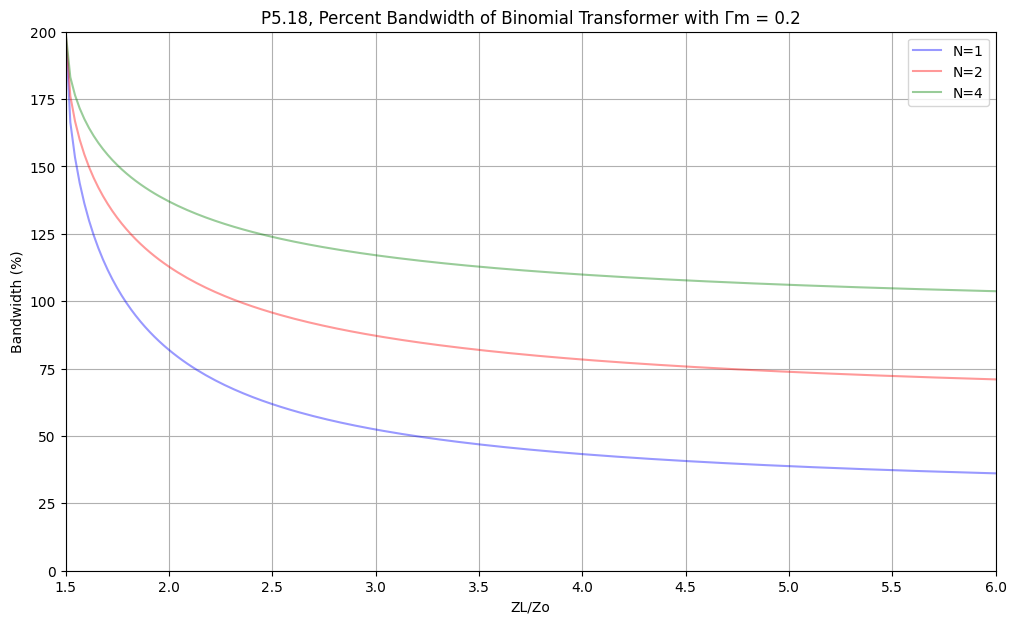

In [13]:
fig = plt.figure(figsize = (12,7))

plt.plot(x_axis,BW_1, alpha = 0.4, label='N=1', color='blue')
plt.plot(x_axis,BW_2, alpha = 0.4, label='N=2', color='red')
plt.plot(x_axis,BW_4, alpha = 0.4, label='N=4', color='green')
plt.title('P5.18, Percent Bandwidth of Binomial Transformer with Γm = 0.2')
plt.xlim(1.5,6)
plt.ylim(0,200)
plt.xlabel('ZL/Zo')
plt.ylabel('Bandwidth (%)')
plt.grid()
plt.legend()

## Problem 5.19

In [110]:
def chebychev_impedence(Zn, Gamma_n) :
    return Zn*(1+Gamma_n)/(1-Gamma_n)

In [125]:
SWR_m = 1.25
Gamma_m = (SWR_m-1)/(SWR_m+1)
#Gamma_m = 0.05
ZL = 30
Zo = 50
#ZL = 100
#Zo = 50
N = 4

A = (ZL-Zo)/(ZL+Zo)
#print(A)

Theta_m = np.arccos(1/(np.cosh((1/N)*np.arccosh(np.abs(np.log(ZL/Zo)/(2*Gamma_m))))))
print(Theta_m*180/pi)
Gamma_0 = -Gamma_m/(2*(np.cos(Theta_m)**4))
Gamma_1 = -2*Gamma_m*(1/(np.cos(Theta_m)**4) - 1/(np.cos(Theta_m)**2))
Gamma_2 = -Gamma_m*(3/(np.cos(Theta_m)**4) - 4/(np.cos(Theta_m)**2) + 1)
Gamma_3 = Gamma_1
Gamma_4 = Gamma_0
Z_1 = chebychev_impedence(Zo,Gamma_0)
Z_2 = chebychev_impedence(Z_1,Gamma_1)
Z_3 = chebychev_impedence(Z_2,Gamma_2)
Z_4 = chebychev_impedence(Z_3,Gamma_3)
Z_5 = chebychev_impedence(Z_4,Gamma_4)
print(Z_4)

20.65694859161171
34.66686794202061
